<a href="https://colab.research.google.com/github/MikelKN/masters_research/blob/master/bert_on_multiclass_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install transformers

     |████████████████████████████████| 1.3MB 10.2MB/s 
     |████████████████████████████████| 1.1MB 51.3MB/s 
     |████████████████████████████████| 2.9MB 53.7MB/s 
     |████████████████████████████████| 890kB 54.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7422b52a141d308bed531bf0b394d74ba670d2fd13410c2e6cb5d2babed5dd23
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
import transformers as ppb
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# # Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)


In [6]:
#Loading the train dataset
import io  
# df = pd.read_csv(io.BytesIO(uploaded['file.csv'])) 
# print(df)
path = "/content/drive/My Drive/Research_2020/my_train_set.csv"
train_df = pd.read_csv(path)
train_df.head()

,Text,ratings,Originally,clean_text,review_len
0,"These crackers, which were shipped to me in No...",0,Food,these crackers which were shipped to me in nov...,354
1,"Just to back up what everyone else is saying, ...",2,Clothing,just to back up what everyone else is saying t...,468
2,I believed the reviews by people saying their ...,0,Food,i believed the review by people saying their d...,328
3,I am an adventurous person who likes new thing...,0,Food,i am an adventurous person who like new thing ...,429
4,What a great price on the coffee pods. HOWEVE...,0,Food,what a great price on the coffee pods however ...,332


Preprocessing data for Bert
BERT expects input data in a specific format i.e

Tokenized dataset All the vectors should be of the same size.Hence,we need to pad the text to achieve a common length.This length will be decided by the length of longest sentence, which we will have to calculate.Also, since we shall concatanate the text and the sentiment column, the length should be decided by the concatanated text column.

We need to then differentiate between the Actual tokens and the Padded ones with the help of "Attention Masks".

From the Hugging face documentation The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them. For the BertTokenizer, 1 indicate a value that should be attended to while 0 indicate a padded value.

Adding special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]).

In [7]:
print('The separation tokens and its encoding: ', tokenizer.sep_token, tokenizer.sep_token_id)
print('The beginning tokens and its encoding: ', tokenizer.cls_token, tokenizer.cls_token_id)

The separation tokens and its encoding:  [SEP] 102
The beginning tokens and its encoding:  [CLS] 101


In [8]:

print('Original sentence: ', train_df['clean_text'][10]) # original sentence
print('\nSentence after tokenization with bert:')
print(tokenizer.tokenize(train_df['clean_text'][10]))

print('\nNOw converting the tokenized sentence into tokens, we get this:')
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_df['clean_text'][10])))

print('\nAdding the beginning and separation tokens:')
print(tokenizer.encode(train_df['clean_text'][10], add_special_tokens=True))

Original sentence:  one of the worst chip that i have had so salty you will not take more than a piece of it

Sentence after tokenization with bert:
['one', 'of', 'the', 'worst', 'chip', 'that', 'i', 'have', 'had', 'so', 'salty', 'you', 'will', 'not', 'take', 'more', 'than', 'a', 'piece', 'of', 'it']

NOw converting the tokenized sentence into tokens, we get this:
[2028, 1997, 1996, 5409, 9090, 2008, 1045, 2031, 2018, 2061, 23592, 2017, 2097, 2025, 2202, 2062, 2084, 1037, 3538, 1997, 2009]

Adding the beginning and separation tokens:
[101, 2028, 1997, 1996, 5409, 9090, 2008, 1045, 2031, 2018, 2061, 23592, 2017, 2097, 2025, 2202, 2062, 2084, 1037, 3538, 1997, 2009, 102]


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_df['clean_text'], train_df['ratings'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=train_df['ratings'])


In [10]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_df['ratings']), train_df['ratings'])

print('The diferent class weights: negs, Movies, Clothing, Fine_food', class_wts)

The diferent class weights: negs, Movies, Clothing, Fine_food [0.4952158  2.1710467  3.10080789 0.83502118]


In [11]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [12]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                        num_labels = 4,
                                        output_attentions=False,
                                        output_hidden_states=False)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

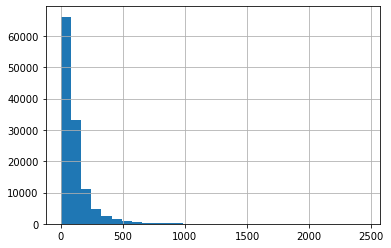

In [13]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
max_seq_len = 250
# tokenize and encode sequences in the training set
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
input_ids_train = torch.tensor(encoded_data_train['input_ids'])
attention_masks_train = torch.tensor(encoded_data_train['attention_mask'])
labels_train = torch.tensor(y_train.tolist())


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)  #to creat the data loaders

In [15]:
# tokenize and encode sequences in the validation set
encoded_data_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

input_ids_val = torch.tensor(encoded_data_val['input_ids'])
attention_masks_val = torch.tensor(encoded_data_val['attention_mask'])
labels_val = torch.tensor(y_val.tolist())

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val) #Wrap tensors

# Data Loaders

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16   #16 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)


In [17]:
# specify GPU
device = torch.device("cuda")

# push the model to GPU
model = model.to(device)

In [18]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (

# Scheduler

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=2e-5,    #was 1e-5
                  eps=1e-8)
                  
epochs = 3    #Between 3 - 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

# Metric Evaluators


In [20]:
label_dict = {'negs': 0, 'Movies':1, 'clothing' : 2 , 'Fine_food' :3}

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

import numpy as np
# Function to calculate the accuracy of our predictions vs labels
'''def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
'''

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

Helper function for formatting elapsed times.

In [21]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

For the purposes of fine-tuning, the authors recommend choosing from the following values:

- Batch size: 16, 32 (We chose 32 when creating our 
DataLoaders).

- Learning rate (Adam): 5e-5, 3e-5, 2e-5 (We’ll use 2e-5).

- Number of epochs: 2, 3, 4 (We’ll use 4).




In [22]:
import random
from tqdm.notebook import tqdm

saved_bert_path = '/content/drive/My Drive/Colab Notebooks/bert/saved_bert'

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        #Unpack this training batch from our dataloader.
        #As we unpack the batch, we'll also copy each tensor to the GPU using the .to(device)
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        #Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 

        with torch.no_grad():        
            outputs = model(**inputs)

         # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification


        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)            
            
    return loss_val_avg, predictions, true_vals

loss_values = []    #To save the loss values or plotting 

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # Store the loss value for plotting the learning curve.
    loss_values.append(loss_train_total)

    #torch.save(model.state_dict(), f'saved_bert_path_{epoch}.model')   #now
    torch.save(model.state_dict(), 'checkpoint.pth')
    #torch.save(model.state_dict(), 'saved_bert_path/checkpoint.pth')   #Save your model

    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.22263266168278917
Validation loss: 0.2011559717012887
F1 Score (Weighted): 0.938809753922146



Epoch 2
Training loss: 0.12401079606572817
Validation loss: 0.1962325625385201
F1 Score (Weighted): 0.9478177176849277



Epoch 3
Training loss: 0.06901849610053067
Validation loss: 0.23356809444852594
F1 Score (Weighted): 0.9493210516909787



# Plotting the Training Loss

In [23]:
import plotly.express as px
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

#Evaluating the model per class

In [24]:
#label_dict = {'negs': 0, 'Movies' : 1, 'clothes': 2, 'food': 3}
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

# download checkpoint file
#bert.download('checkpoint.pth')

model.load_state_dict(torch.load('checkpoint.pth'))

'''#Later to restore:
model.load_state_dict(torch.load('checkpoint.pth'))
model.eval()'''

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Class: negs
Accuracy: 25016/26275

Class: Movies
Accuracy: 5557/5993

Class: clothing
Accuracy: 4083/4196

Class: Fine_food
Accuracy: 14751/15582



In [25]:
plot_labels = []
import matplotlib.pyplot as plt

num_classes = 4
def diff_classes (num_classes):
    for i in range(0, num_classes):
        plot_labels.append(i)
    return(plot_labels)
plot_classes = diff_classes(num_classes)

def compute_confusion_matrix(cm, labels = [0, 1, 2, 3] , title='plot confusion matrix', cmap=plt.cm.Blues):
        
        fig, ax = plt.subplots(figsize=(5,5))

        plt.imshow(cm, cmap=cmap )
        plt.title(title)
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show();

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

'''def diff_classes (num_classes):
    for i in range(0, num_classes):
        plot_labels.append(i)
    return(plot_labels)


plot_classes = diff_classes(num_classes)'''
# model's performance
predictions = np.argmax(predictions, axis = 1)

print('The classification report: ')
target_names = ['class_' + str(i) for i in range(num_classes)]
print(classification_report(true_vals, predictions, target_names=target_names))

The classification report: 
              precision    recall  f1-score   support

     class_0       0.95      0.95      0.95     26275
     class_1       0.91      0.93      0.92      5993
     class_2       0.97      0.97      0.97      4196
     class_3       0.96      0.95      0.95     15582

    accuracy                           0.95     52046
   macro avg       0.95      0.95      0.95     52046
weighted avg       0.95      0.95      0.95     52046



The confusion matrix: 


<Figure size 432x288 with 0 Axes>

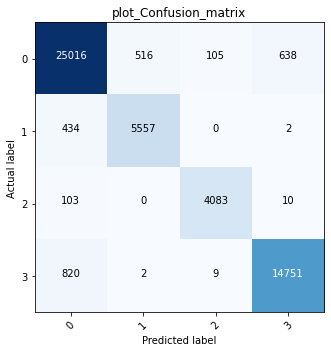

In [29]:
import itertools
print('The confusion matrix: ')
cnf_matrix = confusion_matrix(true_vals, predictions)
plt.figure()

compute_confusion_matrix(cnf_matrix, labels=[0,1,2,3],
                      title='plot_Confusion_matrix')

# My Test Set

In [30]:
#Importing Test Set
path = "/content/drive/My Drive/Research_2020/my_test_set.csv"
test_df = pd.read_csv(path)
test_df.head()

,Text,ratings,Originally,clean_text,review_len
0,"The new Stevia sweetener ruined this, formerly...",0,Food,the new stevia sweetener ruined this formerly ...,173
1,This tea works on my fiance's digestive track ...,3,Food,this tea work on my fiances digestive track a ...,297
2,"This film aka ""the four hundred blows"" is a mi...",0,Movies,this film aka the four hundred blows is a mist...,2568
3,I've order the Seasame Blues before and though...,0,Food,ive order the seasame blue before and thought ...,304
4,The best sauce on the market. We use it on al...,3,Food,the best sauce on the market we use it on almo...,102


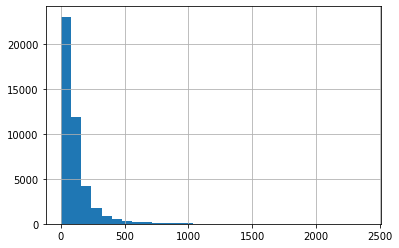

In [32]:
seq_len = [len(i.split()) for i in test_df['clean_text']]

pd.Series(seq_len).hist(bins = 30)

In [33]:
# tokenize and encode sequences in the test set
encoded_data_test = tokenizer.batch_encode_plus(
    test_df['clean_text'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [34]:
input_ids_test = torch.tensor(encoded_data_test['input_ids'])
attention_masks_test = torch.tensor(encoded_data_test['attention_mask'])
labels_test = torch.tensor(test_df['ratings'].tolist())

dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)  #to creat the data loaders

#define a batch size
batch_size = 16   #16 32
dataloader_test = DataLoader(dataset_test, 
                              sampler=SequentialSampler(dataset_test), 
                              batch_size=batch_size)

In [35]:
#load weights of best model
path = 'checkpoint.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [36]:
test_loss, pred_test, true_test = evaluate(dataloader_test)
test_f1 = f1_score_func(pred_test, true_test)
tqdm.write(f'Test Set F1 Score (Weighted): {test_f1}')
print('\nTRAINING? DONE!')

Test Set F1 Score (Weighted): 0.9480333613324718

TRAINING? DONE!


In [39]:
pred_test = np.argmax(pred_test, axis = 1)
print('The classification report for the Test set: ')
target_names = ['class_' + str(i) for i in range(num_classes)]
print(classification_report(true_test, pred_test, target_names=target_names))

The classification report for the Test set: 
              precision    recall  f1-score   support

     class_0       0.95      0.95      0.95     21827
     class_1       0.91      0.92      0.91      5023
     class_2       0.97      0.97      0.97      3461
     class_3       0.96      0.95      0.95     13060

    accuracy                           0.95     43371
   macro avg       0.95      0.95      0.95     43371
weighted avg       0.95      0.95      0.95     43371



The confusion matrix for the Test Set: 


<Figure size 432x288 with 0 Axes>

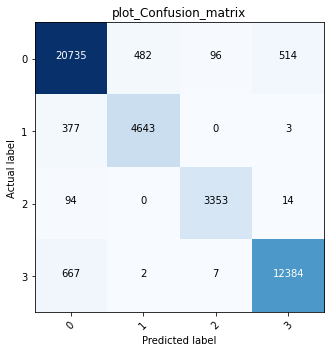

In [41]:
print('The confusion matrix for the Test Set: ')
cnf_matrix = confusion_matrix(true_test, pred_test)
plt.figure()

compute_confusion_matrix(cnf_matrix, labels=[0,1,2,3],
                      title='plot_Confusion_matrix')

In [ ]:
https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch saving pytorch model
# https://medium.com/@aniruddha.choudhury94/part-2-bert-fine-tuning-tutorial-with-pytorch-for-text-classification-on-the-corpus-of-linguistic-18057ce330e1

In [ ]:
https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/